## Intrinsics


## Getting extrinsics

In [31]:
import os
import json
import cv2 as cv
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

class Pattern:
    """
    Chessboard pattern parameters
    """
    def __init__(self, height, width, square_size):
        self.pattern_height = height
        self.pattern_width = width
        self.square_size = float(square_size)
        self.pattern_type = "chessboard"
        self.pattern_size = (self.pattern_width, self.pattern_height)

        self.pattern_points = np.zeros((np.prod(self.pattern_size), 3), np.float32)
        self.pattern_points[:, :2] = np.indices(self.pattern_size).T.reshape(-1, 2)
        self.pattern_points *= square_size

def get_serial_number(filename: str) -> str:
    """
    get the camera serial number from filename
    """
    parts = filename.split("_")
    sn = parts[2]
    return sn


def get_points(img, file_name, output_dir, pattern_params: Pattern):
    found = False
    corners = 0
    found, corners = cv.findChessboardCorners(img, pattern_params.pattern_size)
    if found:
        term = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 50, 0.1)
        cv.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

        frame_img_points = corners.reshape(-1, 2)
        frame_obj_points = pattern_params.pattern_points
    else:
        print("corners not found")
        return None

    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.drawChessboardCorners(vis, pattern_params.pattern_size, corners, found)
    vis = cv.circle(vis,(int(frame_img_points[0][0]), int(frame_img_points[0][1])),10,(255,0,0),2)

    outfile = os.path.join(output_dir, file_name + "_board.png")
    cv.imwrite(outfile, vis)

    print(f"           {outfile}... OK")
    return (frame_img_points, frame_obj_points)

In [34]:
# input/output folders
data_dir = "./data"
output_dir = "./output"
# img_mask = "./data/*.png"

with open("./camera_params.json", "r") as f:
    intrinsic_params = json.load(f)

board_pattern = Pattern(6, 4, 150)


# serial numbers, file names and images
sns_fns_imgs = [
    (get_serial_number(file),
     file.split('.png')[0].split('\\')[1],
    cv.imread(file, cv.IMREAD_GRAYSCALE))
    for file in glob(os.path.join(data_dir, "*.png"))
]

In [36]:
extrinsics = []
coords = []


for sn, fn, img in sns_fns_imgs:
    print(f"Processing {fn}...")
    img_points, obj_points = get_points(img, fn, output_dir, board_pattern)
    cameraMatrix = np.array(intrinsic_params[sn]["left_sensor"]["camera_matrix"])
    distCoeffs = np.array(intrinsic_params[sn]["left_sensor"]["distortion_coeff"])
    success, rvec, tvec = cv.solvePnP(
        obj_points,
        img_points,
        cameraMatrix,
        distCoeffs,
        useExtrinsicGuess=False,
        flags=cv.SOLVEPNP_ITERATIVE,
    )  # CV_P3P ,CV_EPNP
    # success, rvec, tvec, inliners = cv.solvePnPRansac(obj_points, img_points,cameraMatrix,distCoeffs)
    if success:
        print(f"           {fn}... OK")
        extrinsics.append((sn, fn, np.concatenate((rvec, tvec),1).reshape(1,6), rvec, tvec))

        R,jac = cv.Rodrigues(rvec)
        Xw = R.T @ tvec
        coords.append(Xw)
        print(f"distance: {np.linalg.norm(Xw)}")
        print('\n')

    else:
        print(f"           {fn}... FAILED")


Processing Explorer_HD1200_SN43804892_10-32-41...
           ./output\Explorer_HD1200_SN43804892_10-32-41_board.png... OK
           Explorer_HD1200_SN43804892_10-32-41... OK
distance: 3708.7348232673917


Processing Explorer_HD1200_SN43916681_10-32-19...
           ./output\Explorer_HD1200_SN43916681_10-32-19_board.png... OK
           Explorer_HD1200_SN43916681_10-32-19... OK
distance: 3284.089622350283




In [18]:
img_points[0][0]

1535.8739

In [14]:
for coord in coords:
    print(f'distance: {np.linalg.norm(coord)}')

distance: 1771.982058768283
distance: 1908.4862203426926


In [20]:
coords[0]

array([[  117.1224043 ],
       [-1138.95202771],
       [ 1352.40195119]])

## Drawing extrinsics

In [9]:
from numpy import linspace
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # pylint: disable=unused-variable

In [10]:
def draw_camera_boards(
    ax,
    camera_matrix,
    cam_width,
    cam_height,
    scale_focal,
    extrinsics,
    board_width,
    board_height,
    square_size,
    patternCentric,
):
    from matplotlib import cm

    min_values = np.zeros((3, 1))
    min_values = np.inf
    max_values = np.zeros((3, 1))
    max_values = -np.inf

    # calibration pattern is stationary / multicam calibration
    if patternCentric:
        X_moving = create_camera_model(
            camera_matrix, cam_width, cam_height, scale_focal
        )
        X_static = create_board_model(
            extrinsics, board_width, board_height, square_size
        )

    # camera is stationary / multiple patterns
    else:
        X_static = create_camera_model(
            camera_matrix, cam_width, cam_height, scale_focal, True
        )
        X_moving = create_board_model(
            extrinsics, board_width, board_height, square_size
        )

    cm_subsection = linspace(0.0, 1.0, extrinsics.shape[0])
    colors = [cm.jet(x) for x in cm_subsection]

    for i in range(len(X_static)):
        X = np.zeros(X_static[i].shape)
        for j in range(X_static[i].shape[1]):
            X[:, j] = transform_to_matplotlib_frame(np.eye(4), X_static[i][:, j])
        ax.plot3D(X[0, :], X[1, :], X[2, :], color="r")
        min_values = np.minimum(min_values, X[0:3, :].min(1))
        max_values = np.maximum(max_values, X[0:3, :].max(1))

    for idx in range(extrinsics.shape[0]):
        R, _ = cv.Rodrigues(extrinsics[idx, 0:3])
        cMo = np.eye(4, 4)
        cMo[0:3, 0:3] = R
        cMo[0:3, 3] = extrinsics[idx, 3:6]
        for i in range(len(X_moving)):
            X = np.zeros(X_moving[i].shape)
            for j in range(X_moving[i].shape[1]):
                X[0:4, j] = transform_to_matplotlib_frame(
                    cMo, X_moving[i][0:4, j], patternCentric
                )
            ax.plot3D(X[0, :], X[1, :], X[2, :], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3, :].min(1))
            max_values = np.maximum(max_values, X[0:3, :].max(1))

    return min_values, max_values


def create_camera_model(
    camera_matrix, width, height, scale_focal, draw_frame_axis=False
):
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    focal = 2 / (fx + fy)
    f_scale = scale_focal * focal

    # draw image plane
    X_img_plane = np.ones((4, 5))
    X_img_plane[0:3, 0] = [-width, height, f_scale]
    X_img_plane[0:3, 1] = [width, height, f_scale]
    X_img_plane[0:3, 2] = [width, -height, f_scale]
    X_img_plane[0:3, 3] = [-width, -height, f_scale]
    X_img_plane[0:3, 4] = [-width, height, f_scale]

    # draw triangle above the image plane
    X_triangle = np.ones((4, 3))
    X_triangle[0:3, 0] = [-width, -height, f_scale]
    X_triangle[0:3, 1] = [0, -2 * height, f_scale]
    X_triangle[0:3, 2] = [width, -height, f_scale]

    # draw camera
    X_center1 = np.ones((4, 2))
    X_center1[0:3, 0] = [0, 0, 0]
    X_center1[0:3, 1] = [-width, height, f_scale]

    X_center2 = np.ones((4, 2))
    X_center2[0:3, 0] = [0, 0, 0]
    X_center2[0:3, 1] = [width, height, f_scale]

    X_center3 = np.ones((4, 2))
    X_center3[0:3, 0] = [0, 0, 0]
    X_center3[0:3, 1] = [width, -height, f_scale]

    X_center4 = np.ones((4, 2))
    X_center4[0:3, 0] = [0, 0, 0]
    X_center4[0:3, 1] = [-width, -height, f_scale]

    # draw camera frame axis
    X_frame1 = np.ones((4, 2))
    X_frame1[0:3, 0] = [0, 0, 0]
    X_frame1[0:3, 1] = [f_scale / 2, 0, 0]

    X_frame2 = np.ones((4, 2))
    X_frame2[0:3, 0] = [0, 0, 0]
    X_frame2[0:3, 1] = [0, f_scale / 2, 0]

    X_frame3 = np.ones((4, 2))
    X_frame3[0:3, 0] = [0, 0, 0]
    X_frame3[0:3, 1] = [0, 0, f_scale / 2]

    if draw_frame_axis:
        return [
            X_img_plane,
            X_triangle,
            X_center1,
            X_center2,
            X_center3,
            X_center4,
            X_frame1,
            X_frame2,
            X_frame3,
        ]
    else:
        return [X_img_plane, X_triangle, X_center1, X_center2, X_center3, X_center4]


def create_board_model(
    extrinsics, board_width, board_height, square_size, draw_frame_axis=False
):
    width = board_width * square_size
    height = board_height * square_size

    # draw calibration board
    X_board = np.ones((4, 5))
    # X_board_cam = np.ones((extrinsics.shape[0],4,5))
    X_board[0:3, 0] = [0, 0, 0]
    X_board[0:3, 1] = [width, 0, 0]
    X_board[0:3, 2] = [width, height, 0]
    X_board[0:3, 3] = [0, height, 0]
    X_board[0:3, 4] = [0, 0, 0]

    # draw board frame axis
    X_frame1 = np.ones((4, 2))
    X_frame1[0:3, 0] = [0, 0, 0]
    X_frame1[0:3, 1] = [height / 2, 0, 0]

    X_frame2 = np.ones((4, 2))
    X_frame2[0:3, 0] = [0, 0, 0]
    X_frame2[0:3, 1] = [0, height / 2, 0]

    X_frame3 = np.ones((4, 2))
    X_frame3[0:3, 0] = [0, 0, 0]
    X_frame3[0:3, 1] = [0, 0, height / 2]

    if draw_frame_axis:
        return [X_board, X_frame1, X_frame2, X_frame3]
    else:
        return [X_board]


def transform_to_matplotlib_frame(cMo, X, inverse=False):
    M = np.identity(4)
    M[1, 1] = 0
    M[1, 2] = 1
    M[2, 1] = -1
    M[2, 2] = 0

    if inverse:
        return M.dot(inverse_homogeneoux_matrix(cMo).dot(X))
    else:
        return M.dot(cMo.dot(X))


def inverse_homogeneoux_matrix(M):
    R = M[0:3, 0:3]
    T = M[0:3, 3]
    M_inv = np.identity(4)
    M_inv[0:3, 0:3] = R.T
    M_inv[0:3, 3] = -(R.T).dot(T)

    return M_inv

AttributeError: 'tuple' object has no attribute 'shape'

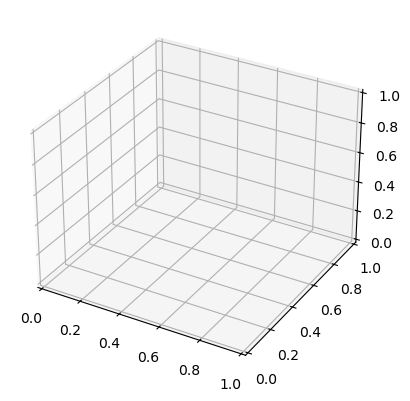

In [46]:
cam_width = 165
cam_height = 35
scale_focal = 40
patternCentric = True


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_aspect("auto")

min_values, max_values = draw_camera_boards(
            ax,
            cameraMatrix,
            cam_width,
            cam_height,
            scale_focal,
            ext,
            board_pattern.pattern_width,
            board_pattern.pattern_height,
            board_pattern.square_size,
            patternCentric,
        )

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max - X_min, Y_max - Y_min, Z_max - Z_min]).max() / 2.0

mid_x = (X_max + X_min) * 0.5
mid_y = (Y_max + Y_min) * 0.5
mid_z = (Z_max + Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("y")
ax.set_title("Extrinsic Parameters Visualization")

ax.view_init(-50, -90)  # align the view with top-left corner
plt.show()
print("Done")

## ChArUco

In [53]:
import cv2 as cv
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import json

In [62]:
# ARUCO_DICT = cv.aruco.DICT_6X6_250
ARUCO_DICT = cv.aruco.DICT_4X4_50
# SQUARES_VERTICALLY = 7
# SQUARES_HORIZONTALLY = 5
# SQUARE_LENGTH = 0.03
# MARKER_LENGTH = 0.015

# SQUARES_VERTICALLY = 6
# SQUARES_HORIZONTALLY = 4
# SQUARE_LENGTH = 0.15
# MARKER_LENGTH = 0.13

SQUARES_VERTICALLY = 5
SQUARES_HORIZONTALLY = 3
SQUARE_LENGTH = 0.15
MARKER_LENGTH = 0.13

LENGTH_PX = 1920   # total length of the page in pixels
MARGIN_PX = 20    # size of the margin in pixels
SAVE_NAME = 'ChArUco_Marker.png'


dictionary = cv.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
size_ratio = SQUARES_HORIZONTALLY / SQUARES_VERTICALLY
img = cv.aruco.CharucoBoard.generateImage(board, (LENGTH_PX, int(LENGTH_PX*size_ratio)), marginSize=MARGIN_PX)
cv.imwrite(SAVE_NAME, img)
im = Image.fromarray(np.uint8(img))
im.save(
    f'./pattern_{SQUARES_HORIZONTALLY}x{SQUARES_VERTICALLY}.pdf', "PDF" ,resolution=100.0)

In [64]:
input_dir = "./phone/*.jpg"

imgs = []
corners = []
ids = []
rejectedImgPoints = []

all_charuco_corners = []
all_charuco_ids = []
flags = (
    cv.CALIB_USE_INTRINSIC_GUESS + cv.CALIB_RATIONAL_MODEL + cv.CALIB_FIX_ASPECT_RATIO
)


for file in glob.glob(input_dir):
    img = cv.imread(file, cv.IMREAD_GRAYSCALE)
    image_copy = img.copy()
    imgSize = img.shape
    # imgs.append(cv.imread(file, cv.IMREAD_GRAYSCALE))

    marker_corners, marker_ids, frame_rejectedImgPoints = cv.aruco.detectMarkers(
        img, dictionary=cv.aruco.getPredefinedDictionary(ARUCO_DICT)
    )
    corners.append(marker_corners)
    ids.append(marker_ids)
    rejectedImgPoints.append(frame_rejectedImgPoints)

    if len(marker_ids) > 0:  # If at least one marker is detected
        # cv.aruco.drawDetectedMarkers(img, marker_corners, marker_ids)
        cv.imwrite('./phone_output/' + file.split('.')[1].split('\\')[1] + "markers.jpg", cv.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids))
        ret, charucoCorners, charucoIds = cv.aruco.interpolateCornersCharuco(
            marker_corners, marker_ids, img, board
        )

        if charucoIds is not None and len(charucoCorners) > 3:
            all_charuco_corners.append(charucoCorners)
            all_charuco_ids.append(charucoIds)

# Calibrate camera with extracted information
(
    ret,
    camera_matrix,
    distortion_coefficients,
    rotation_vectors,
    translation_vectors,
    stdDeviationsIntrinsics,
    stdDeviationsExtrinsics,
    perViewErrors,
) = cv.aruco.calibrateCameraCharucoExtended(
    all_charuco_corners, all_charuco_ids, board, imgSize, flags, None
)

np.save('camera_matrix.npy', camera_matrix)
np.save('dist_coeffs.npy', distortion_coefficients)

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\aruco\src\aruco_calib.cpp:69: error: (-215:Assertion failed) _charucoIds.total() > 0 && (_charucoIds.total() == _charucoCorners.total()) in function 'cv::aruco::calibrateCameraCharuco'


In [59]:
with open("./camera_params.json", "r") as f:
    intrinsic_params = json.load(f)
camera_matrix = intrinsic_params['SN43916681']['left_sensor']['camera_matrix']
dist_coeffs = intrinsic_params['SN43916681']['left_sensor']['distortion_coeff']
camera_matrix


[[1269.29, 0, 962.939], [0, 1268.76, 601.949], [0, 0, 1]]

In [ ]:
# camera_matrix = np.load('./camera_matrix.npy')
# dist_coeffs = np.load('./dist_coeffs.npy')
# ARUCO_DICT = cv.aruco.extendDictionary()
# ARUCO_DICT = cv.aruco.DICT_6X6_50

with open("./camera_params.json", "r") as f:
    intrinsic_params = json.load(f)
    
camera_matrix = np.array(intrinsic_params['SN43916681']['left_sensor']['camera_matrix'])
dist_coeffs = np.array(intrinsic_params['SN43916681']['left_sensor']['distortion_coeff'])

for file in glob.glob(input_dir):
    # img = cv.imread(file, cv.IMREAD_GRAYSCALE)
    img = cv.imread(file)

    image_copy = img.copy()
    imgSize = img.shape

    # Undistort the image
    # undistorted_image = cv.undistort(img, camera_matrix, dist_coeffs)
    undistorted_image = image_copy

    # Define the aruco dictionary and charuco board
    dictionary = cv.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    params = cv.aruco.DetectorParameters()

    # Detect markers in the undistorted image
    marker_corners, marker_ids, _ = cv.aruco.detectMarkers(undistorted_image, dictionary, parameters=params)
    cv.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
    # cv.imwrite('./phone_output/' + file.split('.')[1].split('\\')[1] + "markers.jpg", cv.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids))


    # If at least one marker is detected
    if marker_ids is not None and len(marker_ids) > 0:
        # Interpolate CharUco corners
        charuco_retval, charuco_corners, charuco_ids = cv.aruco.interpolateCornersCharuco(marker_corners, marker_ids, undistorted_image, board)

        # If enough corners are found, estimate the pose
        if charuco_retval:
            print(f'{file}')
            retval, rvec, tvec = cv.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, board, camera_matrix, dist_coeffs, None, None)
            print(f'rotation: {rvec} \n translation: {tvec}')
            # If pose estimation is successful, draw the axis
            if retval:
                cv.drawFrameAxes(undistorted_image, camera_matrix, dist_coeffs, rvec, tvec, length=0.1, thickness=5)

            R, jac = cv.Rodrigues(rvec)
            # Xw = -np.matrix(R).T @ tvec
            Xw = -np.matrix(R).T * np.matrix(tvec)
            # camera_coords.append(Xw)
            print(f"distance: {round(np.linalg.norm(Xw),2)}")
    else:
        print(f'cant find markers for image: {file}')

    cv.imwrite('./phone_output/' + file.split('.')[1].split('\\')[1] + "pose.jpg", undistorted_image)


./phone\cam81.jpg
rotation: [[-1.5119775 ]
 [ 0.01628163]
 [ 2.76198821]] 
 translation: [[0.6329288 ]
 [0.18344414]
 [3.18716048]]
distance: 2.71
./phone\cam92.jpg
rotation: [[-1.62965428]
 [-0.02296871]
 [-2.64431336]] 
 translation: [[-0.15154352]
 [ 0.12612608]
 [ 2.69950322]]
distance: 3.25


In [90]:
for corner in charuco_corners:
    print(corner)




[[1191.1002  615.1784]]
[[1166.1221   614.95886]]
[[1139.2443  614.826 ]]
[[1109.4108  614.3798]]
[[1191.1183  553.1474]]
[[1166.4535   550.15753]]
[[1138.9896  547.0921]]
[[1109.0878   543.99695]]


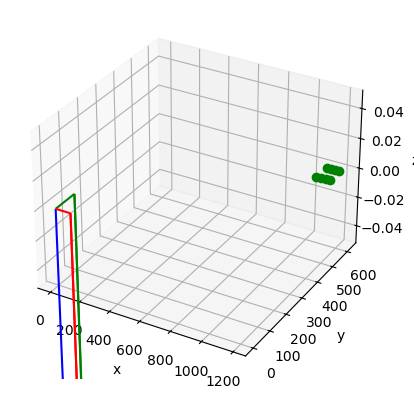

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax.set_aspect("auto")
# ax.set_box_aspect([1, 1, 1])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# ax.set_xlim(-900, 900)
# ax.set_ylim(-900, 900)
# ax.set_zlim(0, 2000)

# Plot axes for reference
ax.quiver(0, 0, 0, 1, 0, 0, color="r", length=100, normalize=True)
ax.quiver(0, 0, 0, 0, 1, 0, color="g", length=100, normalize=True)
ax.quiver(0, 0, 0, 0, 0, 1, color="b", length=100, normalize=True)

# ax.plot([0, 150], [0, 0], zs=[0, 0])


for op in charuco_corners:
    ax.plot3D(op[0][0], op[0][1], 0, "go")


# for coords in camera_coords:
#     ax.plot3D(coords[0], coords[1], coords[2], "r^")
    # ax.plot([0, coords[0][0]], [0, coords[1][0]], [0, coords[1][0]], "r--")

plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt

[0, 0, 0]
[0, 681, 0]
[1135, 681, 0]
[1135, 0, 0]


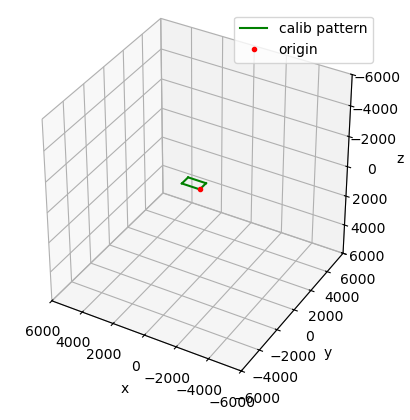

In [ ]:
SQUARES_VERTICALLY = 5  # num squares vertical direction
SQUARES_HORIZONTALLY = 3  # num squares horizontal direction
SQUARE_LENGTH = 227  # in mm
MARKER_LENGTH = 197  # in mm

board_corners = [
    [0, 0, 0],
    [0, SQUARE_LENGTH * SQUARES_HORIZONTALLY, 0],
    [SQUARE_LENGTH * SQUARES_VERTICALLY, SQUARE_LENGTH * SQUARES_HORIZONTALLY, 0],
    [SQUARE_LENGTH * SQUARES_VERTICALLY, 0, 0],
    
]

for row in board_corners:
    print(row)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax.set_aspect("auto")
ax.set_box_aspect([1, 1, 1])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-6000, 6000)
ax.set_ylim(-6000, 6000)
ax.set_zlim(-6000, 6000)

for idx in range(-1,len(board_corners)-1):
    label = '_nolegend_'
    if idx == 0:
        label = 'calib pattern'
    ax.plot(
            [board_corners[idx][0], board_corners[idx + 1][0]],
            [board_corners[idx][1], board_corners[idx + 1][1]],
            [0, 0], "g-", label=label
        )

ax.plot3D(0, 0, 0, "ro", markersize=3, label='origin')
ax.view_init(elev=-145, azim=60)
ax.legend()
plt.show()

In [5]:
class Pattern:
    """
    Chessboard pattern parameters
    """

    def __init__(self, height, width, square_size):
        self.pattern_height = height
        self.pattern_width = width
        self.square_size = float(square_size)
        self.pattern_type = "chessboard"
        self.pattern_size = (self.pattern_width, self.pattern_height)

        self.pattern_points = np.zeros((np.prod(self.pattern_size), 3), np.float32)
        self.pattern_points[:, :2] = np.indices(self.pattern_size).T.reshape(-1, 2)
        self.pattern_points *= square_size

board_pattern = Pattern(5, 3, 150)
board_pattern.pattern_points


array([[  0.,   0.,   0.],
       [150.,   0.,   0.],
       [300.,   0.,   0.],
       [  0., 150.,   0.],
       [150., 150.,   0.],
       [300., 150.,   0.],
       [  0., 300.,   0.],
       [150., 300.,   0.],
       [300., 300.,   0.],
       [  0., 450.,   0.],
       [150., 450.,   0.],
       [300., 450.,   0.],
       [  0., 600.,   0.],
       [150., 600.,   0.],
       [300., 600.,   0.]], dtype=float32)

In [5]:
import glob
input_dir = "./charuco_data/*.jpg"

for file in glob.glob(input_dir):
    print(file.split("_")[1].split('\\')[1])

SN43804892
SN43916681
